In [ ]:
import pandas as pd

# Load the two CSV files
df1 = pd.read_csv("<YOUR_FILEPATH>")
df2 = pd.read_csv("<YOUR_FILEPATH>")

df2.rename(columns={'Unnamed: 0': 'id'}, inplace=True)



# Notebook for combining topographical and weather data

In [ ]:
df2.columns

Index(['id', 'fire_id', 'ig_date', 'fsr_km2_dy', 'tot_ar_km2', 'event_dur',
       'ignition_elev', 'mean_elev', 'min_elev', 'max_elev', 'std_elev',
       'range_elev', 'land_cover', 'ecoregion', 'ignition_slope_deg',
       'ignition_slope_pct', 'ignition_slope_asp', 'ignition_northness',
       'ignition_eastness', 'mean_slope', 'std_slope', 'mean_aspect',
       'aspect_consistency', 'mean_northness', 'mean_eastness'],
      dtype='object')

In [ ]:
# Perform an inner join on the 'id' column
merged_df = pd.merge(df1, df2, on="id", how="inner")

# Drop duplicate rows if any
merged_df = merged_df.drop_duplicates()

# Drop rows with any null values
merged_df = merged_df.dropna()

# Save the result to a new CSV
merged_df.to_csv("merged.csv", index=False)


In [ ]:
print(len(merged_df))
merged_df.head(5)

42840


,id,geometry,ig_date_x,ig_day,ig_month,ig_year,last_date,event_dur_x,tot_pix,tot_ar_km2_x,...,ignition_slope_pct,ignition_slope_asp,ignition_northness,ignition_eastness,mean_slope,std_slope,mean_aspect,aspect_consistency,mean_northness,mean_eastness
5,27,MULTIPOLYGON (((-10039987.656358264 4794359.34...,2018-10-22,295,10,2018,2018-10-22,1,1,0.214659,...,9.0,141.0,-0.777146,0.629320,5.0,0.0,141.0,1.0,-0.777146,0.629320
6,39,MULTIPOLYGON (((-10102070.656358264 4786019.34...,2018-11-17,321,11,2018,2018-11-19,3,6,1.287952,...,11.0,224.0,-0.719340,-0.694658,6.0,0.0,224.0,1.0,-0.719340,-0.694658
7,40,MULTIPOLYGON (((-10059446.656358264 4786482.84...,2018-10-23,296,10,2018,2018-10-23,1,2,0.429317,...,6.0,173.0,-0.992546,0.121869,3.0,0.0,173.0,1.0,-0.992546,0.121869
16,56,MULTIPOLYGON (((-10071492.656358264 4775363.34...,2018-10-22,295,10,2018,2018-10-22,1,2,0.429317,...,39.0,306.0,0.587785,-0.809017,22.0,0.0,306.0,1.0,0.587785,-0.809017
22,71,MULTIPOLYGON (((-10056664.343641736 4761463.84...,2019-07-23,204,7,2019,2019-08-01,10,217,46.580932,...,15.0,351.0,0.987688,-0.156434,9.0,0.0,351.0,1.0,0.987688,-0.156434


# Eval

In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load your cleaned merged CSV
df = pd.read_csv("merged.csv", nrows=5000)



In [ ]:
print('tot_pix' in df.columns)

True


In [5]:
from sklearn.preprocessing import LabelEncoder

y = df["fsr_km2_dy_x"]

X = df.drop(columns=["fsr_km2_dy_x", "id", "ig_date_x", 'geometry', 'ig_date_x', 'ig_day', 'ig_month', 'ig_year',
       'fsr_px_dy', 'mx_grw_px', 'mn_grw_px', 'mu_grw_px', 'mx_grw_km2',
       'mn_grw_km2', 'mu_grw_km2', 'mx_grw_dte', 'x', 'y','last_date',
       'event_dur_x', 'tot_pix', 'tot_ar_km2_x', 'ig_utm_x', 'ig_utm_y',
       'lat', 'lon', 'lc_code', 'lc_mode', 'lc_desc', 'lc_type',
       'eco_mode', 'eco_type', 'tot_perim', 'event_dates'])

# Label encode all object or category dtype columns
for col in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


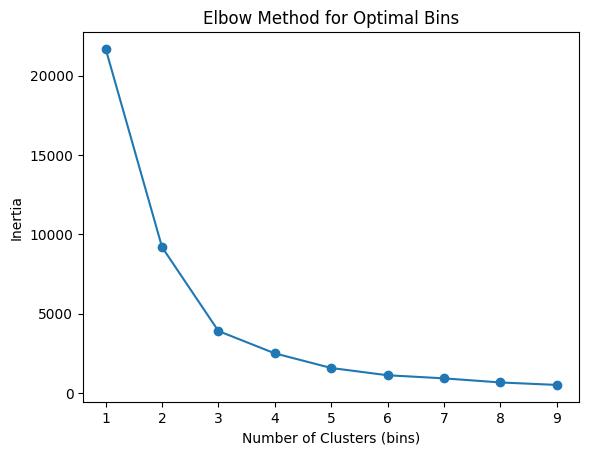

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(y.values.reshape(-1, 1))
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters (bins)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Bins')
plt.show()


In [7]:
from sklearn.metrics import silhouette_score

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(y.values.reshape(-1, 1))
    score = silhouette_score(y.values.reshape(-1, 1), labels)
    print(f"{k} clusters: Silhouette Score = {score:.3f}")


2 clusters: Silhouette Score = 0.966
3 clusters: Silhouette Score = 0.947
4 clusters: Silhouette Score = 0.936
5 clusters: Silhouette Score = 0.894
6 clusters: Silhouette Score = 0.848


In [8]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Fit a decision tree regressor
tree = DecisionTreeRegressor(max_leaf_nodes=3, random_state=42)
tree.fit(X, y)

# Extract thresholds from the trained tree
thresholds = np.sort(tree.tree_.threshold[tree.tree_.threshold != -2])
print("Suggested thresholds:", thresholds)


Suggested thresholds: [ 1.98479271 95.37649155]


In [9]:
from sklearn.cluster import KMeans
import numpy as np

# Reshape target to fit KMeans
y_values = y.values.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=42).fit(y_values)

# Use cluster labels as bins
y_binned = pd.Series(kmeans.labels_, index=y.index)


In [11]:
# y_class = pd.cut(y, bins=[-np.inf, 0.5, 20.87999821, np.inf], labels=["Low", "Medium", "High"])
y_class = pd.cut(y, bins=[-np.inf, 1.98479271 , 95.37649155, np.inf], labels=["Low", "Medium", "High"])


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train_class)
y_pred_class = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test_class, y_pred_class))
print(classification_report(y_test_class, y_pred_class))


Accuracy: 0.967
              precision    recall  f1-score   support

         Low       0.97      1.00      0.98       967
      Medium       0.00      0.00      0.00        33

    accuracy                           0.97      1000
   macro avg       0.48      0.50      0.49      1000
weighted avg       0.94      0.97      0.95      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:


# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("R² Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))


R² Score: -0.5557864939067771
Mean Squared Error: 4.671273734912083


In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))


KeyboardInterrupt: 

In [15]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("MSE:", mean_squared_error(y_test, y_pred_xgb))


XGBoost R²: -0.7398795951500594
MSE: 5.224016204386037


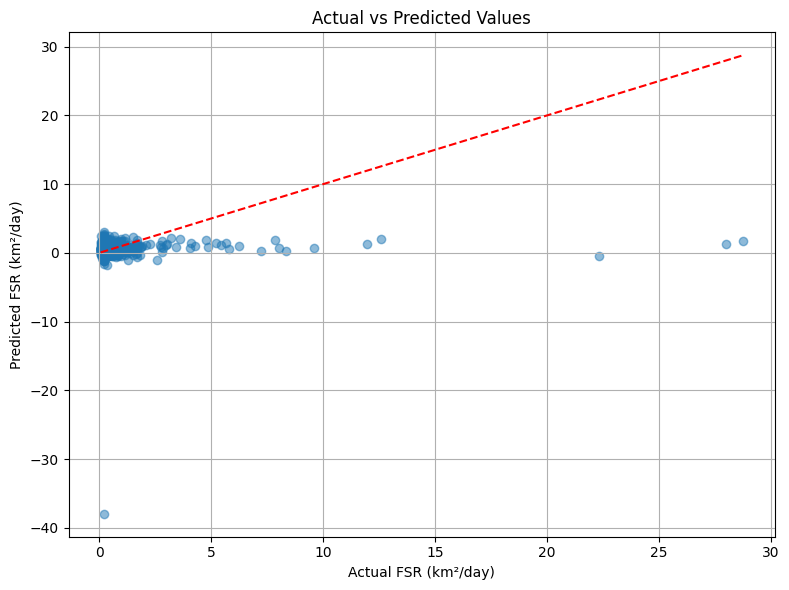

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual FSR (km²/day)")
plt.ylabel("Predicted FSR (km²/day)")
plt.title("Actual vs Predicted Values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # identity line
plt.grid(True)
plt.tight_layout()
plt.show()


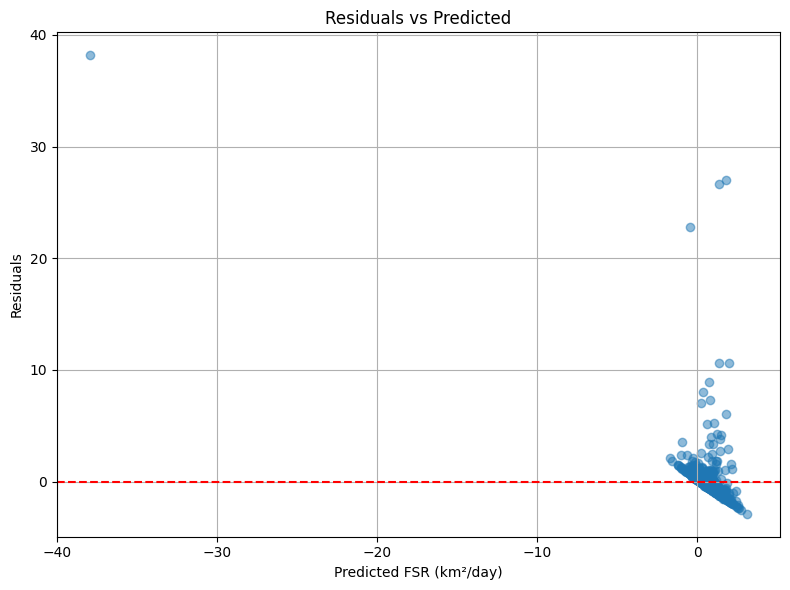

In [17]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted FSR (km²/day)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


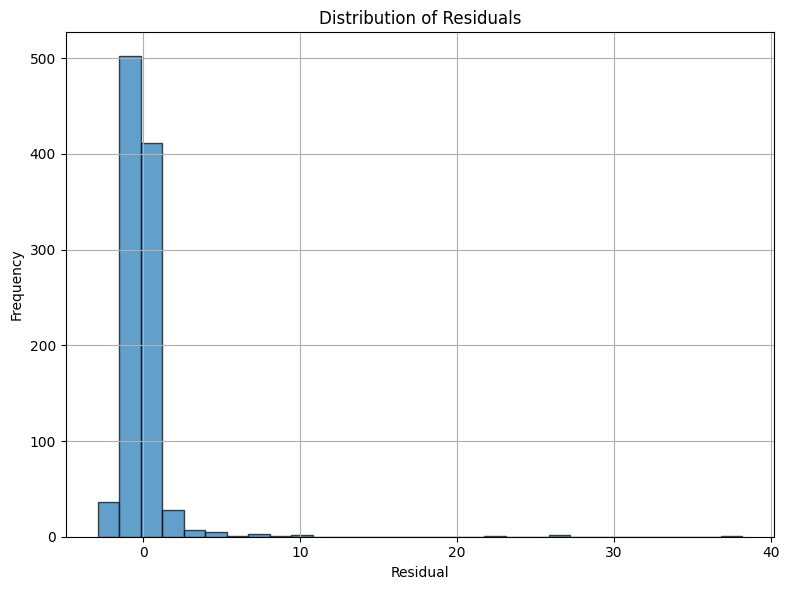

In [18]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()
